In [1]:
import numpy as np

import pandas as pd

from zse.collections import *
from zse.utilities import *

from ase.io import read, write
from matplotlib import cm
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.cluster import KMeans

from collections import defaultdict

from sklearn.metrics import silhouette_samples, silhouette_score, completeness_score, homogeneity_score, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.preprocessing import StandardScaler

import itertools
from itertools import permutations

from sklearn.preprocessing import MinMaxScaler
import sys

from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator


In [2]:
def get_fw_data(file,code):
    
    # file is the file we want to read from
    # code is the IZA framework code you want data on
    
    file = open(file,'r')
    data = file.readlines()
    file.close()
    
    for i,line in enumerate(data):
        fields = line.split()
        if fields[0] == code:
            start = i
            break
    
    # go through fw chunk and get data
    
    t_sites = {}
    o_sites = {}
    for i,line in enumerate(data[start+1:]):
        line = line.rstrip(' \n')

        # get the t site rings
        
        if 'T' in line and ':' in line:
            fields = line.split(':')
            t_sites[fields[0]]=fields[1]                
        
        # get the o site rings
        
        if 'O' in line and ':' in line:
            fields = line.split(':')
            o_sites[fields[0]]=fields[1]        
        
        fields = line.split()
        if fields[0] == 'Framework':
            end = i+start-1
            break

    return(t_sites,o_sites)    

def numofrings(file,code):
    #might already be a function called counter so come up with very unique names otherwsie function overrides it -- isseue with kernel resets
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: number of each rings inside'''
    
    #call function to get data
    tsites, osites = get_fw_data(file,code)
    
    for t in tsites:
        #print('check 1')
        #resets dictionary each tsite
        tsite_dict = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
        #ways to make dictionary without knowing what it is 
        
        #make into vector not dictionary 
        
        #restarts j to 1 to check for ring size
        j = 1
        #go through all of the one tsite
        for i in range(0,len(tsites[t])-2,2):
            #print('check 2')
            #set yes to true
            print('i is',i)
            yes = True
            while yes:
                #print('check 3')
                #print(tsites[t][i])
                #print(int(tsites[t][i]) == j)
                #print(tsite_dict[j])
                #number of rings matches dictionary component
                if int(tsites[t][i]) == j:
                    print('check 4')
                    tsite_dict[j] = tsite_dict[j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    
                    j = j + 1
                    print('j is',j)
        print(t,tsite_dict)
        

def nringsvector(code,file):
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: vector of number of rings for each tsite'''
    
    #get site data
    tsites, osites = get_fw_data(file,code)
    
    #create empty vector
    A = np.zeros([len(tsites),21])
    
    #coutner for which row of the matrix you are in
    k=0 
    
    #go through each tsite
    for t in tsites:
        #initialize accumulator 
        j=1
        
        #make list of number of rings
        tsites_list = tsites[t].split('_')
        #go through the string for each t list
        for i in range(0,len(tsites_list)):
            #make the while loop true each for loop
            yes = True
            while yes:
                if int(tsites_list[i]) == j:
                    A[k][j] = A[k][j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    j = j + 1
        #increase row
        k = k +1 
    return A

def assemblematrix(file):
    fws = get_all_fws()
    fws = fws[1:]
    B = nringsvector('ABW',file)
    for code in fws:
        C = nringsvector(code,file)
        B = np.append(B, C, axis=0)
    return B

def kmeans_percent(file,ncluster):
    A = assemblematrix(file)
    clustering = KMeans(n_clusters = ncluster).fit(A)
    cluster = clustering.labels_

    sorted_clusters = defaultdict(list) #inside parentheses put the type of value ie list int

    fws = get_all_fws()
    #testing to see if Tsite make it a similar cluster
    dict_fws = {}
    count = 0
    for code in fws:
        dict_fws[code] = []
        tsites, osites = get_fw_data(file,code)
        for t in tsites:
            dict_fws[code].append(cluster[count])
            count = count + 1
    allsame = 0
    no1 = 0
    for k in dict_fws:
        if len(dict_fws[k]) > 1:
            no1 = no1 + 1
            avg = sum(dict_fws[k])/len(dict_fws[k])
            if avg == dict_fws[k][0]:
                if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                    allsame = allsame + 1
    per = allsame/no1
    return per, dict_fws 

def weight_avg(file):
    '''Takes in a files frameworks and makes a wieghted average for each framewokr
        Arguments: file - whichever defintion of ring used
        returns: an array of the values'''
    fws = get_all_fws()
    fws_weights = np.zeros([len(fws),21])
    count = 0
    for code in fws:
        #get tsite sata
        tsites, osites = get_fw_data(file,code)
        ts, tm, ti = get_tsites(code)
        #number of tsites
        n = len(tsites)
        #get the matrix of the tsite vectors
        rings = nringsvector(code,file)
        temp = np.zeros(len(rings[0]))
        #to move through the rings matrix
        ring_count = 0
        #calculate weights and add them rows of tsite values together
        for s,m,i in zip(ts,tm,ti):
            #calculate weight
            w = m/sum(tm)
            #make weighted framework
            temp = w*rings[ring_count] + temp
            ring_count = ring_count + 1
        fws_weights[count] = temp
        #increase row number
        count = count + 1
    return fws_weights

def compare4(A,B,nclusters,rand_state,vbool=False):
    #get data 
    Azlist, Aist = Kmeansresults(A,nclusters,rand_state,False)
    Bzlist, Bist = Kmeansresults(B,nclusters,rand_state,False)

    #print(Aist)
    #print(Bist)
    #make default dictionaries to reorganzie the zlist
    Alist = defaultdict(list)
    Blist = defaultdict(list)
    
    #sort the dictionaries numerically
    m = 0
    for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
    m = 0
    for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
        Blist[m] = Bzlist[k]
        m = m + 1   
    # combinations
    unique_combinations = []
 
    # Getting all permutations of list_1
    # with length of list_2
    permut = itertools.permutations(Alist, len(Blist))
    # zip() is called to pair each permutation
    # and shorter list element into combination
    for comb in permut:
        zipped = zip(comb, Blist)
        unique_combinations.append(list(zipped))
       
    
    #create an array to store values
    array_values = np.zeros([nclusters,nclusters])
    #print('')
    #loop over unique combinations 
    for n in range(nclusters):
        for i in range(nclusters):
            #index into the first part of the ordered pair
            a = unique_combinations[n][i][0]
            #index into the second part of the ordered pair
            b = unique_combinations[n][i][1]
            #find what is in common with the two lists 
            c = list(set(Alist[a]).intersection(Blist[b]))
            #add the value to the array
            array_values[n,i] = len(c)
    #print(array_values)
    #print('')
    
    #store results 
    temp = []
    #print results 
    for t in range(nclusters):
        #print(sum(array_values[t])/253)
        temp.append(sum(array_values[t])/253)
        
    return temp

def isNaN(num):
    return num!= num

def properties(A,values,nclusters,vbool=False):
    '''Arguments:
    
        A: the assembled matrix
        nclusters: number of clusters
        values: data framework to be texted'''
    #get all the frameworks
    fws = get_all_fws()
    #get the clusters
    Azlist, Aist = Kmeansresults(A,nclusters,vbool)
    print(Aist)
    #create a values dictionary to store the frameworks IZa values
    value_dict = defaultdict(list)
    #go through all the clusters
    for k in Azlist:
        #go through all the frameworks in each cluster
        for i in range(len(Azlist[k])):
            #find the index for the framework
            idx = fws.index(Azlist[k][i])
            if isNaN(values[idx]) != True:
                #add the framework's values to the dictionary
                value_dict[k].append(int(values[idx]))
    
    
    #list of the averages
    avg = []
    #list of the standard deviations
    stdev = []
    for k in value_dict:
        x = sum(value_dict[k])/len(value_dict[k])
        avg.append(x)
        y = np.std(value_dict[k])
        stdev.append(y)
                   
    return avg, stdev

def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=9).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist


In [3]:
fws = get_all_fws
iza_values =pd.read_csv('../data/iza_data.csv')
fws = iza_values['Framework'].values
rings = iza_values['Rings'].values
ntsite = iza_values['Number of T Sites'].values
accessiblevolume = iza_values['Accessible Volume %'].values
mdiametera = iza_values['Max diameter along a'].values
mdiameterb = iza_values['Max diameter along b'].values
mdiameterc = iza_values['Max diameter along c'].values
alpha = iza_values['alpha'].values
beta = iza_values['beta'].values
gamma = iza_values['gamma'].values
mdiameter = iza_values['Max Diameter (Å)'].values
density = iza_values['Density (T sites/ 1000 Å^3)'].values

print(iza_values.columns)

Index(['Unnamed: 0', 'Framework', 'a (Å)', 'b', 'c', 'alpha', 'beta', 'gamma',
       'Volume (Å^3)', 'Density (T sites/ 1000 Å^3)', 'Rings',
       'Max Diameter (Å)', 'Max diameter along a', 'Max diameter along b',
       'Max diameter along c', 'Accessible Volume %', 'Number of T Sites'],
      dtype='object')


In [4]:
A = weight_avg('../Data/vertex_rings.txt')
B = weight_avg('../Data/sastre_rings.txt')
C = weight_avg('../Data/crum_rings.txt')
D = weight_avg('../Data/goetzke_rings.txt')


scaler = MinMaxScaler()
# transform data
scaledA = scaler.fit_transform(A)
scaledB = scaler.fit_transform(B)
scaledC = scaler.fit_transform(C)
scaledD = scaler.fit_transform(D)

In [11]:
nclusters = 11
d = defaultdict(list)
for i in range(50):
    x,y = Kmeansresults(scaledA,11,False)
    y.sort()
    for n in range(nclusters):
        d[n].append( y[n])
for t in range(nclusters):
    print(t)
    print('STD',np.std(d[t]))
    print('Avg',sum(d[t])/50)
    print(t)

[1, 3, 4, 7, 13, 16, 22, 38, 38, 53, 58]
[1, 3, 4, 8, 20, 20, 26, 35, 38, 45, 53]
[1, 1, 3, 4, 7, 8, 21, 43, 52, 55, 58]
[4, 4, 6, 9, 15, 25, 26, 31, 42, 43, 48]
[3, 4, 4, 9, 15, 19, 25, 33, 43, 49, 49]
[1, 4, 6, 6, 9, 15, 21, 41, 48, 49, 53]
[1, 3, 4, 4, 9, 15, 20, 46, 46, 52, 53]
[1, 4, 5, 9, 11, 17, 29, 37, 42, 48, 50]
[1, 3, 4, 7, 13, 16, 28, 39, 40, 50, 52]
[1, 3, 4, 4, 8, 18, 30, 38, 46, 50, 51]
[4, 6, 7, 10, 14, 21, 22, 35, 39, 40, 55]
[1, 3, 4, 9, 10, 20, 23, 36, 45, 48, 54]
[1, 1, 3, 4, 8, 17, 24, 37, 47, 54, 57]
[3, 4, 9, 16, 20, 20, 24, 34, 38, 39, 46]
[1, 4, 9, 10, 15, 21, 22, 36, 42, 42, 51]
[1, 4, 9, 11, 19, 22, 23, 35, 40, 42, 47]
[1, 3, 4, 4, 8, 10, 20, 40, 51, 55, 57]
[1, 3, 4, 9, 10, 16, 21, 39, 42, 53, 55]
[1, 3, 4, 8, 10, 16, 21, 39, 42, 54, 55]
[1, 3, 4, 4, 8, 21, 23, 36, 45, 52, 56]
[1, 4, 6, 8, 10, 20, 23, 36, 40, 52, 53]
[1, 3, 4, 4, 8, 17, 26, 37, 42, 54, 57]
[3, 4, 4, 8, 16, 23, 26, 36, 42, 42, 49]
[1, 4, 7, 9, 11, 16, 22, 40, 41, 48, 54]
[3, 3, 4, 9, 10, 16, 

In [12]:
nclusters = 20
d = defaultdict(list)
for i in range(50):
    x,y = Kmeansresults(scaledA,nclusters,False)
    y.sort()
    for n in range(nclusters):
        d[n].append( y[n])
for t in range(nclusters):
    print(t)
    print('STD',np.std(d[t]))
    print('Avg',sum(d[t])/50)
    print(t)

0
STD 0.0
Avg 1.0
0
1
STD 0.0
Avg 1.0
1
2
STD 0.0
Avg 1.0
2
3
STD 0.0
Avg 1.0
3
4
STD 0.0
Avg 1.0
4
5
STD 0.8506468127254695
Avg 1.58
5
6
STD 1.085172797300043
Avg 2.68
6
7
STD 0.4915282290977803
Avg 3.72
7
8
STD 0.8
Avg 4.2
8
9
STD 1.4914422550001727
Avg 5.66
9
10
STD 2.5675669416784443
Avg 8.26
10
11
STD 2.597614290074645
Avg 11.18
11
12
STD 1.7233687939614086
Avg 13.7
12
13
STD 2.2181073012818833
Avg 15.6
13
14
STD 2.39407602218476
Avg 18.22
14
15
STD 2.8775684179529075
Avg 21.86
15
16
STD 5.088378916708149
Avg 27.78
16
17
STD 2.988310559496787
Avg 34.3
17
18
STD 2.4540578640284747
Avg 37.76
18
19
STD 3.6565010597564442
Avg 41.5
19


In [29]:
savg = np.zeros(20)
sstd = np.zeros(20)

print('Vertex density')
x,y = properties(scaledA,density,20,False)
print('avg is',x)
print('std is',y)
savg = savg + x
sstd = sstd + y 
print('')
print('Sastre density')
x,y = properties(scaledB,density,20,False)
print('avg is',x)
print('std is',y)
savg = savg + x
sstd = sstd + y 
print('')
print('Crum density')
x,y=properties(scaledC,density,20,False)
print('avg is',x)
print('std is',y)
savg = savg + x
sstd = sstd + y 
print('')
print('Goetzke density')
x,y=properties(scaledA,density,20,False)
print('avg is',x)
print('std is',y)
savg = savg + x
sstd = sstd + y 

print(savg)
print(sstd)
print(savg/4)
print(sstd/4)

Vertex density
avg is [16.105263157894736, 16.306122448979593, 17.714285714285715, 15.5, 16.357142857142858, 16.65714285714286, 15.416666666666666, 15.666666666666666, 16.857142857142858, 18.0, 16.0, 16.5, 16.0, 15.0, 15.0, 17.666666666666668, 16.25, 15.75, 17.0, 16.0]
std is [1.7135600627473373, 1.5010755549741464, 1.3850513878332367, 2.8136571693556887, 2.5803416954554916, 1.6025489899863037, 2.3078970706877047, 2.321398046197353, 1.8844151368961313, 0.0, 1.7213259316477407, 2.5, 0.0, 0.0, 0.0, 1.247219128924647, 1.299038105676658, 1.299038105676658, 0.0, 0.0]

Sastre density
avg is [16.363636363636363, 16.21951219512195, 18.0, 16.375, 17.0, 16.166666666666668, 16.05, 15.5, 15.941176470588236, 16.75, 18.0, 16.058823529411764, 16.42105263157895, 16.0, 15.0, 17.0, 14.0, 16.25, 15.5, 16.0]
std is [1.3666633071248098, 1.5851782252948214, 1.1281521496355325, 1.964529205687714, 2.449489742783178, 2.576604138956718, 1.9615045245933032, 2.6457513110645907, 2.0713902190187072, 1.7853571071357

In [30]:


df = pd.DataFrame([savg/4, sstd/4]).T
df.columns = ['Average Density','Average Standard Devation']
#df = pd.DataFrame ([savg,sstd], columns = ['Average Density','Average Standard Devation'])



In [31]:
print(df)

    Average Density  Average Standard Devation
0         16.218933                   1.615483
1         16.206262                   1.625765
2         17.928571                   1.180370
3         16.227083                   2.362336
4         16.482143                   2.173549
5         15.975302                   2.332422
6         15.976042                   2.144086
7         16.505952                   1.712891
8         16.690651                   1.403433
9         17.194643                   1.120964
10        16.750000                   1.680331
11        16.258754                   1.473380
12        15.855263                   0.482017
13        16.187500                   0.369755
14        15.500000                   0.408248
15        16.833333                   1.031858
16        15.725000                   1.199519
17        15.250000                   1.003072
18        15.625000                   0.375000
19        15.750000                   0.000000


In [38]:
unique_combinations = []
list1 = [0,1,2,3,4,5,6,7,8,9]
# Getting all permutations of list_1
# with length of list_2
permut = itertools.permutations(list1, len(list1))
type(permut)
# zip() is called to pair each permutation
# and shorter list element into combination

# printing unique_combination list
#print(unique_combinations)

itertools.permutations

In [36]:
i = 0
for comb in permut:
    zipped = zip(comb, list1)
    unique_combinations.append(list(zipped))

    i = i + 1
print(len(unique_combinations)) 

KeyboardInterrupt: 

In [39]:
list1 = range(10)
list2 = range(10,20)

unique_comb = list(itertools.product(list1,list2))

for u in unique_comb:
    print(u)

(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(4, 10)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 19)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(5, 16)
(5, 17)
(5, 18)
(5, 19)
(6, 10)
(6, 11)
(6, 12)
(6, 13)
(6, 14)
(6, 15)
(6, 16)
(6, 17)
(6, 18)
(6, 19)
(7, 10)
(7, 11)
(7, 12)
(7, 13)
(7, 14)
(7, 15)
(7, 16)
(7, 17)
(7, 18)
(7, 19)
(8, 10)
(8, 11)
(8, 12)
(8, 13)
(8, 14)
(8, 15)
(8, 16)
(8, 17)
(8, 18)
(8, 19)
(9, 10)
(9, 11)
(9, 12)
(9, 13)
(9, 14)
(9, 15)
(9, 16)
(9, 17)
(9, 18)
(9, 19)


In [48]:
for i in range(10):
    x,y = Kmeansresults(scaledA,3,False)
    print(y)


[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]
[26, 97, 130]


In [54]:
for i in range(10):
    x,y = Kmeansresults(scaledD,10,False)
    print(y)


[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]
[33, 38, 54, 15, 26, 42, 25, 11, 5, 4]


In [55]:
print(x[9])

['KFI', 'LTA', 'RHO', 'UFI']


In [57]:
for i in range(10):
    x,y = Kmeansresults(scaledB,10,False)
    print(y)

[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]
[4, 18, 50, 45, 16, 57, 46, 10, 3, 4]


In [58]:
print(x[9])

['MEI', 'MTF', 'SFG', 'VET']


In [59]:
print(x[8])

['JRY', 'MVY', 'PON']


In [60]:
print(x[0])

['LOV', 'NAB', 'RSN', 'VSV']


In [61]:
for i in range(10):
    x,y = Kmeansresults(scaledA,10,False)
    print(y)

[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]
[54, 38, 63, 16, 3, 9, 40, 22, 4, 4]


In [62]:
print(x[8])
print(x[9])

['CZP', 'EDI', 'NAT', 'THO']
['LOV', 'NAB', 'RSN', 'VSV']


In [5]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=1).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

In [9]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],3,False))
        compare_array[n,c] = max(compare4(i,keys[n],3,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

[97, 130, 26]
[97, 130, 26]
1.0
0.5138339920948617
0.10276679841897234
[97, 130, 26]
[97, 130, 26]
1.0
0.5138339920948617
0.10276679841897234
[97, 130, 26]
[114, 89, 50]
0.9051383399209486
0.48221343873517786
0.10276679841897234
[97, 130, 26]
[114, 89, 50]
0.9051383399209486
0.48221343873517786
0.10276679841897234
[97, 130, 26]
[131, 96, 26]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[97, 130, 26]
[131, 96, 26]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[97, 130, 26]
[82, 90, 81]
0.525691699604743
0.1976284584980237
0.06324110671936758
[97, 130, 26]
[82, 90, 81]
0.525691699604743
0.1976284584980237
0.06324110671936758
[114, 89, 50]
[114, 89, 50]
1.0
0.4505928853754941
0.1976284584980237
[114, 89, 50]
[114, 89, 50]
1.0
0.4505928853754941
0.1976284584980237
[114, 89, 50]
[131, 96, 26]
0.9051383399209486
0.4782608695652174
0.10276679841897234
[114, 89, 50]
[131, 96, 26]
0.9051383399209486
0.4782608695652174
0.10276679841897234
[114, 89, 50]
[82, 90, 81]
0.462

In [10]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],4,False))
        compare_array[n,c] = max(compare4(i,keys[n],4,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

[115, 95, 27, 16]
[115, 95, 27, 16]
1.0
0.8300395256916996
0.5177865612648221
0.45454545454545453
[115, 95, 27, 16]
[115, 95, 27, 16]
1.0
0.8300395256916996
0.5177865612648221
0.45454545454545453
[115, 95, 27, 16]
[14, 28, 95, 116]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[115, 95, 27, 16]
[14, 28, 95, 116]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[115, 95, 27, 16]
[116, 95, 15, 27]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[115, 95, 27, 16]
[116, 95, 15, 27]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[115, 95, 27, 16]
[98, 118, 15, 22]
0.9565217391304348
0.8142292490118577
0.49407114624505927
0.43873517786561267
[115, 95, 27, 16]
[98, 118, 15, 22]
0.9565217391304348
0.8142292490118577
0.49407114624505927
0.43873517786561267
[14, 28, 95, 116]
[14, 28, 95, 116]
1.0
0.83399209486166
0.5138339920948617
0.45849802371541504
[14, 28, 95, 116]
[14, 28, 95, 1

In [11]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],5,False))
        compare_array[n,c] = max(compare4(i,keys[n],5,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

[98, 61, 26, 16, 52]
[98, 61, 26, 16, 52]
1.0
0.83399209486166
0.691699604743083
0.6284584980237155
0.6284584980237155
[98, 61, 26, 16, 52]
[98, 61, 26, 16, 52]
1.0
0.83399209486166
0.691699604743083
0.6284584980237155
0.6284584980237155
[98, 61, 26, 16, 52]
[54, 99, 15, 61, 24]
0.9762845849802372
0.8300395256916996
0.6758893280632411
0.6205533596837944
0.6245059288537549
[98, 61, 26, 16, 52]
[54, 99, 15, 61, 24]
0.9762845849802372
0.8300395256916996
0.6758893280632411
0.6205533596837944
0.6245059288537549
[98, 61, 26, 16, 52]
[99, 64, 51, 23, 16]
0.9723320158102767
0.8300395256916996
0.6798418972332015
0.6245059288537549
0.6284584980237155
[98, 61, 26, 16, 52]
[99, 64, 51, 23, 16]
0.9723320158102767
0.8300395256916996
0.6798418972332015
0.6245059288537549
0.6284584980237155
[98, 61, 26, 16, 52]
[19, 54, 100, 16, 64]
0.9446640316205533
0.8181818181818182
0.6640316205533597
0.6086956521739131
0.6126482213438735
[98, 61, 26, 16, 52]
[19, 54, 100, 16, 64]
0.9446640316205533
0.818181818181

In [13]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],5,False))
        compare_array[n,c] = max(compare4(i,keys[n],5,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.984190  0.976285  0.932806
Sastre   0.984190  1.000000  0.992095  0.936759
Crum     0.976285  0.992095  1.000000  0.944664
Goetzke  0.932806  0.936759  0.944664  1.000000


In [14]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],6,False))
        compare_array[n,c] = max(compare4(i,keys[n],6,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.913043  0.881423  0.794466
Sastre   0.913043  1.000000  0.956522  0.774704
Crum     0.881423  0.956522  1.000000  0.782609
Goetzke  0.794466  0.774704  0.782609  1.000000


In [15]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],7,False))
        compare_array[n,c] = max(compare4(i,keys[n],7,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.343874  0.324111  0.367589
Sastre   0.343874  1.000000  0.909091  0.743083
Crum     0.324111  0.909091  1.000000  0.802372
Goetzke  0.367589  0.743083  0.802372  1.000000


In [16]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],8,False))
        compare_array[n,c] = max(compare4(i,keys[n],8,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.197628  0.146245  0.363636
Sastre   0.197628  1.000000  0.719368  0.312253
Crum     0.146245  0.719368  1.000000  0.335968
Goetzke  0.363636  0.312253  0.335968  1.000000


In [17]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],9,False))
        compare_array[n,c] = max(compare4(i,keys[n],9,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.122530  0.071146  0.359684
Sastre   0.122530  1.000000  0.798419  0.245059
Crum     0.071146  0.798419  1.000000  0.256917
Goetzke  0.359684  0.245059  0.256917  1.000000


In [18]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=9).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

In [19]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],9,False))
        compare_array[n,c] = max(compare4(i,keys[n],9,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.122530  0.071146  0.359684
Sastre   0.122530  1.000000  0.798419  0.245059
Crum     0.071146  0.798419  1.000000  0.256917
Goetzke  0.359684  0.245059  0.256917  1.000000


In [20]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],8,False))
        compare_array[n,c] = max(compare4(i,keys[n],8,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.197628  0.146245  0.363636
Sastre   0.197628  1.000000  0.719368  0.312253
Crum     0.146245  0.719368  1.000000  0.335968
Goetzke  0.363636  0.312253  0.335968  1.000000


In [21]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=20).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],8,False))
        compare_array[n,c] = max(compare4(i,keys[n],8,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.035573  0.272727  0.375494
Sastre   0.035573  1.000000  0.525692  0.300395
Crum     0.272727  0.525692  1.000000  0.695652
Goetzke  0.375494  0.300395  0.695652  1.000000


In [22]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=500).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],8,False))
        compare_array[n,c] = max(compare4(i,keys[n],8,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.719368  0.743083  0.166008
Sastre   0.719368  1.000000  0.754941  0.090909
Crum     0.743083  0.754941  1.000000  0.138340
Goetzke  0.166008  0.090909  0.138340  1.000000


In [23]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=100).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],8,False))
        compare_array[n,c] = max(compare4(i,keys[n],8,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.098814  0.237154  0.387352
Sastre   0.098814  1.000000  0.284585  0.150198
Crum     0.237154  0.284585  1.000000  0.086957
Goetzke  0.387352  0.150198  0.086957  1.000000


In [24]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=1000).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0
d = 0
for i in keys:
    for n in range(d,4):
        compare_array[c,n] = max(compare4(i,keys[n],8,False))
        compare_array[n,c] = max(compare4(i,keys[n],8,False))
    c = c + 1
    d = d + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.711462  0.727273  0.213439
Sastre   0.711462  1.000000  0.944664  0.090909
Crum     0.727273  0.944664  1.000000  0.098814
Goetzke  0.213439  0.090909  0.098814  1.000000


In [5]:
def Kmeansresults(A,n,rand_state,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n,random_state=rand_state).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    #llist.sort()
    
    return zlist, llist

keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],5,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],5,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.976285  0.972332  0.944664
Sastre   0.976285  1.000000  0.980237  0.948617
Crum     0.972332  0.980237  1.000000  0.960474
Goetzke  0.944664  0.948617  0.960474  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.984190  0.972332  0.924901
Sastre   0.984190  1.000000  0.980237  0.936759
Crum     0.972332  0.980237  1.000000  0.932806
Goetzke  0.924901  0.936759  0.932806  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.984190  0.976285  0.932806
Sastre   0.984190  1.000000  0.984190  0.948617
Crum     0.976285  0.984190  1.000000  0.956522
Goetzke  0.932806  0.948617  0.956522  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.984190  0.976285  0.948617
Sastre   0.984190  1.000000  0.984190  0.952569
Crum     0.976285  0.984190  1.000000  0.952569
Goetzke  0.948617  0.952569  0.952569  1.000000
           Vertex    Sastre      Crum   

In [32]:
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],6,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],6,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.233202  0.197628  0.189723
Sastre   0.233202  1.000000  0.944664  0.774704
Crum     0.197628  0.944664  1.000000  0.802372
Goetzke  0.189723  0.774704  0.802372  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.936759  0.905138  0.786561
Sastre   0.936759  1.000000  0.948617  0.766798
Crum     0.905138  0.948617  1.000000  0.782609
Goetzke  0.786561  0.766798  0.782609  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.438735  0.403162  0.387352
Sastre   0.438735  1.000000  0.940711  0.778656
Crum     0.403162  0.940711  1.000000  0.794466
Goetzke  0.387352  0.778656  0.794466  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.909091  0.877470  0.778656
Sastre   0.909091  1.000000  0.948617  0.770751
Crum     0.877470  0.948617  1.000000  0.802372
Goetzke  0.778656  0.770751  0.802372  1.000000
           Vertex    Sastre      Crum   

In [ ]:
#vertex and sastre math well mostly for 5
#very depenedet on the random state 

In [33]:
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],6,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],6,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.233202  0.197628  0.189723
Sastre   0.233202  1.000000  0.944664  0.774704
Crum     0.197628  0.944664  1.000000  0.802372
Goetzke  0.189723  0.774704  0.802372  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.936759  0.905138  0.786561
Sastre   0.936759  1.000000  0.948617  0.766798
Crum     0.905138  0.948617  1.000000  0.782609
Goetzke  0.786561  0.766798  0.782609  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.438735  0.403162  0.387352
Sastre   0.438735  1.000000  0.940711  0.778656
Crum     0.403162  0.940711  1.000000  0.794466
Goetzke  0.387352  0.778656  0.794466  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.909091  0.877470  0.778656
Sastre   0.909091  1.000000  0.948617  0.770751
Crum     0.877470  0.948617  1.000000  0.802372
Goetzke  0.778656  0.770751  0.802372  1.000000
           Vertex    Sastre      Crum   

In [34]:
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],7,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],7,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.185771  0.375494  0.371542
Sastre   0.185771  1.000000  0.521739  0.371542
Crum     0.375494  0.521739  1.000000  0.766798
Goetzke  0.371542  0.371542  0.766798  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.395257  0.371542  0.363636
Sastre   0.395257  1.000000  0.913043  0.743083
Crum     0.371542  0.913043  1.000000  0.735178
Goetzke  0.363636  0.743083  0.735178  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.411067  0.411067  0.363636
Sastre   0.411067  1.000000  0.909091  0.735178
Crum     0.411067  0.909091  1.000000  0.778656
Goetzke  0.363636  0.735178  0.778656  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.114625  0.869565  0.754941
Sastre   0.114625  1.000000  0.114625  0.166008
Crum     0.869565  0.114625  1.000000  0.786561
Goetzke  0.754941  0.166008  0.786561  1.000000
           Vertex    Sastre      Crum   

In [35]:
x = np.linspace(1,500,20)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],8,int(t),False))
            compare_array[n,c] = max(compare4(i,keys[n],8,int(t),False))
        c = c + 1
        d = d + 1
    #print(compare_array) 

    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.845850  0.482213  0.695652
Sastre   0.845850  1.000000  0.490119  0.679842
Crum     0.482213  0.490119  1.000000  0.320158
Goetzke  0.695652  0.679842  0.320158  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.154150  0.735178  0.217391
Sastre   0.154150  1.000000  0.079051  0.577075
Crum     0.735178  0.079051  1.000000  0.090909
Goetzke  0.217391  0.577075  0.090909  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.284585  0.284585  0.339921
Sastre   0.284585  1.000000  0.928854  0.695652
Crum     0.284585  0.928854  1.000000  0.703557
Goetzke  0.339921  0.695652  0.703557  1.000000
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.422925  0.470356  0.367589
Sastre   0.422925  1.000000  0.284585  0.122530
Crum     0.470356  0.284585  1.000000  0.731225
Goetzke  0.367589  0.122530  0.731225  1.000000
           Vertex    Sastre      Crum   

In [76]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],8,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
    print(df)
    print(y)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)   

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.845850  0.482213  0.695652
Sastre   0.845850  1.000000  0.490119  0.679842
Crum     0.482213  0.490119  1.000000  0.320158
Goetzke  0.695652  0.679842  0.320158  1.000000
defaultdict(<class 'list'>, {0: [1.0], 1: [0.8458498023715415], 2: [0.48221343873517786], 3: [0.6956521739130435], 4: [1.0], 5: [0.4901185770750988], 6: [0.6798418972332015], 7: [1.0], 8: [0.3201581027667984], 9: [1.0]})
           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.154150  0.735178  0.217391
Sastre   0.154150  1.000000  0.079051  0.577075
Crum     0.735178  0.079051  1.000000  0.090909
Goetzke  0.217391  0.577075  0.090909  1.000000
defaultdict(<class 'list'>, {0: [1.0, 1.0], 1: [0.8458498023715415, 0.1541501976284585], 2: [0.48221343873517786, 0.7351778656126482], 3: [0.6956521739130435, 0.21739130434782608], 4: [1.0, 1.0], 5: [0.4901185770750988, 0.07905138339920949], 6: [0.6798418972332015, 0.5770750988142292], 7: [1.0, 1.0

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.260870  0.351779  0.561265
Sastre   0.260870  1.000000  0.071146  0.264822
Crum     0.351779  0.071146  1.000000  0.415020
Goetzke  0.561265  0.264822  0.415020  1.000000
defaultdict(<class 'list'>, {0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1: [0.8458498023715415, 0.1541501976284585, 0.2845849802371542, 0.42292490118577075, 0.1225296442687747, 0.35177865612648224, 0.4308300395256917, 0.9011857707509882, 0.2490118577075099, 0.2608695652173913], 2: [0.48221343873517786, 0.7351778656126482, 0.2845849802371542, 0.47035573122529645, 0.7035573122529645, 0.04743083003952569, 0.03557312252964427, 0.09090909090909091, 0.2648221343873518, 0.35177865612648224], 3: [0.6956521739130435, 0.21739130434782608, 0.33992094861660077, 0.3675889328063241, 0.758893280632411, 0.308300395256917, 0.3675889328063241, 0.7905138339920948, 0.3557312252964427, 0.5612648221343873], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.304348  0.264822  0.363636
Sastre   0.304348  1.000000  0.770751  0.747036
Crum     0.264822  0.770751  1.000000  0.703557
Goetzke  0.363636  0.747036  0.703557  1.000000
defaultdict(<class 'list'>, {0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1: [0.8458498023715415, 0.1541501976284585, 0.2845849802371542, 0.42292490118577075, 0.1225296442687747, 0.35177865612648224, 0.4308300395256917, 0.9011857707509882, 0.2490118577075099, 0.2608695652173913, 0.2766798418972332, 0.31225296442687744, 0.2608695652173913, 0.6482213438735178, 0.30434782608695654], 2: [0.48221343873517786, 0.7351778656126482, 0.2845849802371542, 0.47035573122529645, 0.7035573122529645, 0.04743083003952569, 0.03557312252964427, 0.09090909090909091, 0.2648221343873518, 0.35177865612648224, 0.23715415019762845, 0.24110671936758893, 0.9130434782608695, 0.31620553359683795, 0.2648221343873518], 3: [0.6956521739130435, 0.21

           Vertex    Sastre      Crum   Goetzke
Vertex   1.000000  0.901186  0.537549  0.747036
Sastre   0.901186  1.000000  0.525692  0.695652
Crum     0.537549  0.525692  1.000000  0.328063
Goetzke  0.747036  0.695652  0.328063  1.000000
defaultdict(<class 'list'>, {0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1: [0.8458498023715415, 0.1541501976284585, 0.2845849802371542, 0.42292490118577075, 0.1225296442687747, 0.35177865612648224, 0.4308300395256917, 0.9011857707509882, 0.2490118577075099, 0.2608695652173913, 0.2766798418972332, 0.31225296442687744, 0.2608695652173913, 0.6482213438735178, 0.30434782608695654, 0.5217391304347826, 0.2648221343873518, 0.525691699604743, 0.9011857707509882], 2: [0.48221343873517786, 0.7351778656126482, 0.2845849802371542, 0.47035573122529645, 0.7035573122529645, 0.04743083003952569, 0.03557312252964427, 0.09090909090909091, 0.2648221343873518, 0.35177865612648224, 0.23715415019762845, 0.2411067193

In [46]:
y[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [47]:
y[1]

[0.8458498023715415,
 0.1541501976284585,
 0.2845849802371542,
 0.42292490118577075,
 0.1225296442687747,
 0.35177865612648224,
 0.4308300395256917,
 0.9011857707509882,
 0.2490118577075099,
 0.2608695652173913,
 0.2766798418972332,
 0.31225296442687744,
 0.2608695652173913,
 0.6482213438735178,
 0.30434782608695654,
 0.5217391304347826,
 0.2648221343873518,
 0.525691699604743,
 0.9011857707509882,
 0.7193675889328063]

In [48]:
y[2]

[0.48221343873517786,
 0.7351778656126482,
 0.2845849802371542,
 0.47035573122529645,
 0.7035573122529645,
 0.04743083003952569,
 0.03557312252964427,
 0.09090909090909091,
 0.2648221343873518,
 0.35177865612648224,
 0.23715415019762845,
 0.24110671936758893,
 0.9130434782608695,
 0.31620553359683795,
 0.2648221343873518,
 0.25296442687747034,
 0.2450592885375494,
 0.2885375494071146,
 0.5375494071146245,
 0.7430830039525692]

In [49]:
y[3]

[0.6956521739130435,
 0.21739130434782608,
 0.33992094861660077,
 0.3675889328063241,
 0.758893280632411,
 0.308300395256917,
 0.3675889328063241,
 0.7905138339920948,
 0.3557312252964427,
 0.5612648221343873,
 0.23715415019762845,
 0.38735177865612647,
 0.4031620553359684,
 0.22134387351778656,
 0.36363636363636365,
 0.383399209486166,
 0.07509881422924901,
 0.42292490118577075,
 0.7470355731225297,
 0.16600790513833993]

In [50]:
y[4]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [51]:
y[5]

[0.4901185770750988,
 0.07905138339920949,
 0.9288537549407114,
 0.2845849802371542,
 0.07114624505928854,
 0.2885375494071146,
 0.3715415019762846,
 0.1067193675889328,
 0.8893280632411067,
 0.07114624505928854,
 0.7193675889328063,
 0.8142292490118577,
 0.33201581027667987,
 0.2766798418972332,
 0.7707509881422925,
 0.08695652173913043,
 0.932806324110672,
 0.11857707509881422,
 0.525691699604743,
 0.7549407114624506]

In [52]:
y[6]

[0.6798418972332015,
 0.5770750988142292,
 0.6956521739130435,
 0.1225296442687747,
 0.2134387351778656,
 0.7509881422924901,
 0.7707509881422925,
 0.7509881422924901,
 0.6758893280632411,
 0.2648221343873518,
 0.6640316205533597,
 0.09486166007905138,
 0.3675889328063241,
 0.24110671936758893,
 0.7470355731225297,
 0.7272727272727273,
 0.25691699604743085,
 0.7233201581027668,
 0.6956521739130435,
 0.09090909090909091]

In [53]:
y[7]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [54]:
y[8]

[0.3201581027667984,
 0.09090909090909091,
 0.7035573122529645,
 0.7312252964426877,
 0.7312252964426877,
 0.28063241106719367,
 0.3241106719367589,
 0.09881422924901186,
 0.691699604743083,
 0.4150197628458498,
 0.766798418972332,
 0.09881422924901186,
 0.4624505928853755,
 0.6758893280632411,
 0.7035573122529645,
 0.08300395256916997,
 0.2608695652173913,
 0.07509881422924901,
 0.32806324110671936,
 0.1383399209486166]

In [55]:
y[9]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [56]:
#9,7,4,0

[]

In [63]:
sd1 = np.std(y[1])
print(sd1)

0.23801096866167387


In [64]:
sd2 = np.std(y[2])
print(sd2)

0.2372248741711013


In [65]:
sd3 = np.std(y[3])
print(sd3)

0.19801257138098324


In [66]:
sd5 = np.std(y[5])
print(sd5)

0.3123426973682764


In [67]:
sd6 = np.std(y[6])
print(sd6)

0.25386727470587056


In [68]:
sd8 = np.std(y[8])
print(sd8)

0.2555343610613127


In [77]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],7,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
sd1 = np.std(y[1])
print(sd1) 
sd2 = np.std(y[2])
print(sd2)
sd3 = np.std(y[3])
print(sd3)
sd5 = np.std(y[5])
print(sd5)
sd6 = np.std(y[6])
print(sd6)
sd8 = np.std(y[8])
print(sd8)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)


0.2821754466737973
0.25227982956643186
0.1941777799670601
0.23880715089213933
0.25221688892475524
0.30086399875214315
averages
0.4654150197628459
0.47509881422924904
0.49723320158102774
0.7818181818181817
0.5330039525691701
0.5636363636363637


In [78]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],6,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
sd1 = np.std(y[1])
print(sd1) 
sd2 = np.std(y[2])
print(sd2)
sd3 = np.std(y[3])
print(sd3)
sd5 = np.std(y[5])
print(sd5)
sd6 = np.std(y[6])
print(sd6)
sd8 = np.std(y[8])
print(sd8)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)

0.20367000602835614
0.23274046660379177
0.1859770950564641
0.15133166124829173
0.08757327095601918
0.17081365048420066
averages
0.842885375494071
0.7511857707509881
0.6944664031620553
0.884387351778656
0.7553359683794467
0.7142292490118577


In [80]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],5,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
sd1 = np.std(y[1])
print(sd1) 
sd2 = np.std(y[2])
print(sd2)
sd3 = np.std(y[3])
print(sd3)
sd5 = np.std(y[5])
print(sd5)
sd6 = np.std(y[6])
print(sd6)
sd8 = np.std(y[8])
print(sd8)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)

0.1488366674421276
0.1674195346042622
0.01404553115512366
0.1632773505305291
0.1481928826429536
0.17160922416876834
averages
0.91501976284585
0.8749011857707509
0.9282608695652173
0.8895256916996047
0.8802371541501977
0.849604743083004


In [81]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],4,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
sd1 = np.std(y[1])
print(sd1) 
sd2 = np.std(y[2])
print(sd2)
sd3 = np.std(y[3])
print(sd3)
sd5 = np.std(y[5])
print(sd5)
sd6 = np.std(y[6])
print(sd6)
sd8 = np.std(y[8])
print(sd8)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)

0.2919193100211922
0.29377162909917764
0.32326144407306423
0.12778403051963164
0.22596841747205335
0.22946859798316008
averages
0.7824110671936758
0.8304347826086957
0.7102766798418974
0.8982213438735178
0.8233201581027668
0.8476284584980236


In [82]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],9,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
sd1 = np.std(y[1])
print(sd1) 
sd2 = np.std(y[2])
print(sd2)
sd3 = np.std(y[3])
print(sd3)
sd5 = np.std(y[5])
print(sd5)
sd6 = np.std(y[6])
print(sd6)
sd8 = np.std(y[8])
print(sd8)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)

0.1133600352252809
0.16471072338148007
0.1283149091077364
0.31098607256204147
0.228232292925712
0.2831860654584878
averages
0.26857707509881423
0.33043478260869563
0.27707509881422926
0.3786561264822135
0.27529644268774706
0.41976284584980234


In [83]:
'4'
0.2919193100211922
0.29377162909917764
0.32326144407306423
0.12778403051963164
0.22596841747205335
0.22946859798316008
averages
0.7824110671936758
0.8304347826086957
0.7102766798418974
0.8982213438735178
0.8233201581027668
0.8476284584980236


'5'
0.1488366674421276
0.1674195346042622
0.01404553115512366
0.1632773505305291
0.1481928826429536
0.17160922416876834
averages
0.91501976284585
0.8749011857707509
0.9282608695652173
0.8895256916996047
0.8802371541501977
0.849604743083004

'6'
0.20367000602835614
0.23274046660379177
0.1859770950564641
0.15133166124829173
0.08757327095601918
0.17081365048420066
averages
0.842885375494071
0.7511857707509881
0.6944664031620553
0.884387351778656
0.7553359683794467
0.7142292490118577

'7'

0.2821754466737973
0.25227982956643186
0.1941777799670601
0.23880715089213933
0.25221688892475524
0.30086399875214315
averages
0.4654150197628459
0.47509881422924904
0.49723320158102774
0.7818181818181817
0.5330039525691701
0.5636363636363637

'8'
.23801096866167387
0.2372248741711013
0.19801257138098324
0.3123426973682764
0.25386727470587056
0.2555343610613127

averages
0.4379446640316205
0.37529644268774703
0.40849802371541494
0.44565217391304346
0.5055335968379449
0.3990118577075099

NameError: name 'averages' is not defined

In [84]:
print('Vertex-Sastre')
print('std')
print(np.std(0.2919193100211922,0.1488366674421276,0.20367000602835614,0.2821754466737973,.23801096866167387))
print('avg')
print(np.mean(0.7824110671936758,0.91501976284585,0.842885375494071,0.4654150197628459,0.4379446640316205))

print('Vertex-Crum')
print('std')
print(np.std(0.29377162909917764,0.1674195346042622,0.23274046660379177,0.25227982956643186,0.2372248741711013))
print('avg')
print(np.mean(0.8304347826086957,0.8749011857707509,0.7511857707509881,0.47509881422924904,0.37529644268774703))

print('Vertex-Goetzke')
print('std')
print(np.std(0.32326144407306423,0.01404553115512366,0.1859770950564641,0.1941777799670601,0.19801257138098324))
print('avg')
#print(np.mean())

Vertex-Sastre
std


TypeError: integer argument expected, got float

In [85]:
keys = [scaledA,scaledB,scaledC,scaledD]
x = np.linspace(1,500,20)
y = defaultdict(list)
a = defaultdict(list)
for t in x:
    compare_array = np.zeros([4,4])

    c = 0
    d = 0
    z = 0
    for i in keys:
        for n in range(d,4):
            compare_array[c,n] = max(compare4(i,keys[n],3,int(t),False))
            compare_array[n,c] = compare_array[c,n]
            y[z].append(compare_array[c,n])
            a[z].append(compare_array[c,n])
            z = z + 1
        c = c + 1
        d = d + 1
    #print(compare_array) 
    
    df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
    df.index = ['Vertex','Sastre','Crum','Goetzke']
sd1 = np.std(y[1])
print(sd1) 
sd2 = np.std(y[2])
print(sd2)
sd3 = np.std(y[3])
print(sd3)
sd5 = np.std(y[5])
print(sd5)
sd6 = np.std(y[6])
print(sd6)
sd8 = np.std(y[8])
print(sd8)
print('averages')
av1 = np.mean(a[1])
print(av1) 
av2 = np.mean(a[2])
print(av2)
av3 = np.mean(a[3])
print(av3)
av5 = np.mean(a[5])
print(av5)
av6 = np.mean(a[6])
print(av6)
av8 = np.mean(a[8])
print(av8)

0.03729422338565788
0.004936757310986863
0.12337525373079924
0.038937821951757844
0.15447556115921302
0.12377980114952661
averages
0.9401185770750988
0.9849802371541502
0.7956521739130434
0.9365612648221344
0.8306324110671935
0.7972332015810276


ValueError: y should be a 1d array, got an array of shape () instead.

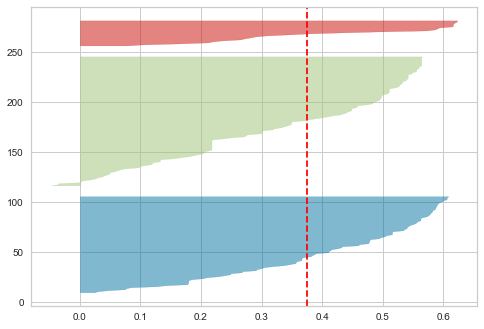

In [103]:
x = np.linspace(1,500,20)
for t in x:
    model = KMeans(3)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(scaledA)
    print(silhouette_score(scaledA,3))

Text(0, 0.5, 'Density (T sites/ 1000 Å^3)')

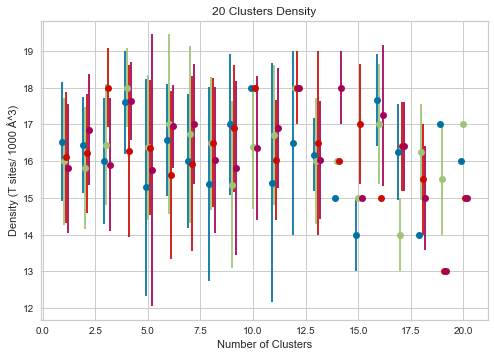

In [104]:
x = np.linspace(1,20,20)

vx, vy = properties(scaledA,density,20,vbool=False)

sx, sy = properties(scaledB,density,20,vbool=False)

cx, cy = properties(scaledC,density,20,vbool=False)

gx, gy = properties(scaledD,density,20,vbool=False)

#plt.plot(x,vx,'o',label = 'Vertex')
#plt.plot(x,sx,'o',label = 'Sastre')
#plt.plot(x,cx,'o',label = 'Crum')
#plt.plot(x,gx,'o',label = 'Goetzke')

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x-.1, vx, yerr=vy, fmt='o',label = 'Vertex')
ax0.errorbar(x, sx, yerr=sy, fmt='o',label = 'Sastre')
ax0.errorbar(x+.1, cx, yerr=cy, fmt='o',label = 'Crum')
ax0.errorbar(x+.2, gx, yerr=gy, fmt='o',label = 'Goetzke')
plt.title('20 Clusters Density')
plt.xlabel('Number of Clusters')
plt.ylabel('Density (T sites/ 1000 Å^3)')

[21, 15, 5, 11, 22, 20, 25, 2, 4, 3, 1, 4, 1, 1, 1, 14, 1, 2, 1, 1, 19, 1, 6, 18, 15, 1, 3, 4, 11, 20]


Text(0, 0.5, 'Accessible Volume %')

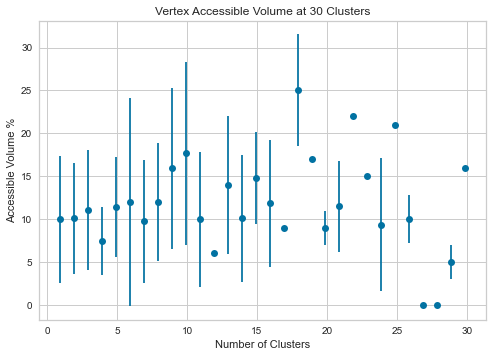

In [115]:
x = np.linspace(1,30,30)

vx, vy = properties(scaledA,accessiblevolume,30,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x-.1, vx, yerr=vy, fmt='o',label = 'Vertex')
plt.title('Vertex Accessible Volume at 30 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accessible Volume %')

[12, 27, 6, 2, 11, 4, 7, 13, 20, 33, 1, 1, 1, 2, 6, 11, 23, 1, 1, 15, 4, 3, 2, 1, 17, 17, 1, 1, 9, 1]


Text(0, 0.5, 'Accessible Volume %')

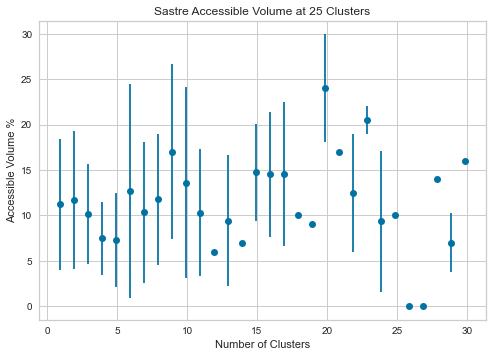

In [116]:
x = np.linspace(1,30,30)

vx, vy = properties(scaledB,accessiblevolume,30,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x-.1, vx, yerr=vy, fmt='o',label = 'Sastre')
plt.title('Sastre Accessible Volume at 25 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accessible Volume %')

In [110]:
# clusters of 0 std are only 1 cluster 

[22, 4, 16, 11, 21, 6, 3, 6, 11, 1, 3, 1, 2, 12, 1, 1, 8, 1, 1, 10, 1, 1, 3, 1, 1, 1, 14, 2, 1, 4, 11, 2, 5, 6, 3, 7, 2, 1, 1, 11, 5, 1, 21, 6, 1]


Text(0, 0.5, 'Accessible Volume %')

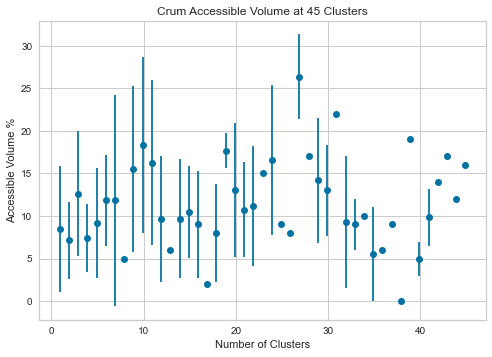

In [117]:
x = np.linspace(1,45,45)

vx, vy = properties(scaledC,accessiblevolume,45,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x-.1, vx, yerr=vy, fmt='o',label = 'Crum')
plt.title('Crum Accessible Volume at 45 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accessible Volume %')

[25, 11, 4, 7, 7, 1, 1, 12, 17, 3, 4, 2, 5, 3, 1, 16, 1, 3, 1, 14, 8, 1, 1, 1, 10, 1, 5, 2, 2, 1, 2, 1, 2, 3, 3, 19, 1, 3, 3, 9, 1, 1, 1, 16, 3, 1, 1, 2, 10, 1]


Text(0, 0.5, 'Accessible Volume %')

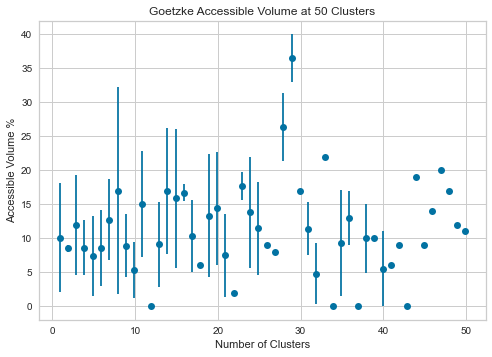

In [118]:
x = np.linspace(1,50,50)

vx, vy = properties(scaledD,accessiblevolume,50,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x-.1, vx, yerr=vy, fmt='o',label = 'Goetzke')
plt.title('Goetzke Accessible Volume at 50 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accessible Volume %')

[21, 15, 5, 11, 22, 20, 25, 2, 4, 3, 1, 4, 1, 1, 1, 14, 1, 2, 1, 1, 19, 1, 6, 18, 15, 1, 3, 4, 11, 20]


Text(0, 0.5, 'Max Diameter (Å)')

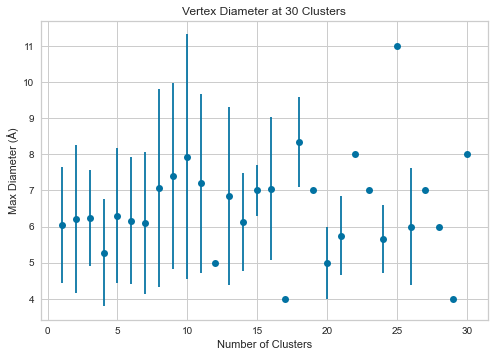

In [122]:
x = np.linspace(1,30,30)

vx, vy = properties(scaledA,mdiameter,30,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x, vx, yerr=vy, fmt='o',label = 'Vertex')
plt.title('Vertex Diameter at 30 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Max Diameter (Å)')

[17, 42, 15, 13, 7, 3, 5, 15, 35, 34, 2, 3, 1, 1, 35, 4, 1, 1, 4, 15]


Text(0, 0.5, 'Max Diameter (Å)')

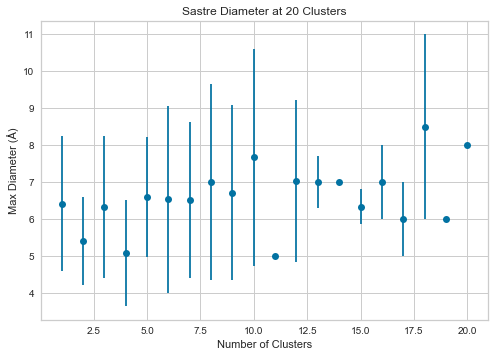

In [123]:
x = np.linspace(1,20,20)

vx, vy = properties(scaledB,mdiameter,20,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x, vx, yerr=vy, fmt='o',label = 'Sastre')
plt.title('Sastre Diameter at 20 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Max Diameter (Å)')

[24, 16, 9, 15, 9, 3, 23, 1, 15, 2, 7, 2, 1, 7, 3, 20, 1, 1, 4, 1, 1, 14, 1, 1, 1, 1, 4, 5, 3, 1, 1, 22, 11, 2, 21]


Text(0, 0.5, 'Max Diameter (Å)')

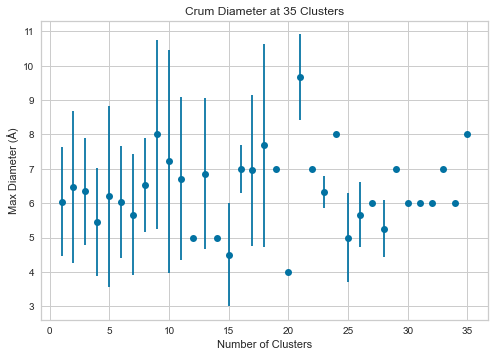

In [125]:
x = np.linspace(1,35,35)

vx, vy = properties(scaledC,mdiameter,35,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x, vx, yerr=vy, fmt='o',label = 'Crum')
plt.title('Crum Diameter at 35 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Max Diameter (Å)')

[19, 13, 5, 11, 31, 3, 9, 20, 27, 5, 50, 1, 2, 3, 7, 1, 3, 10, 2, 31]


Text(0, 0.5, 'Max Diameter (Å)')

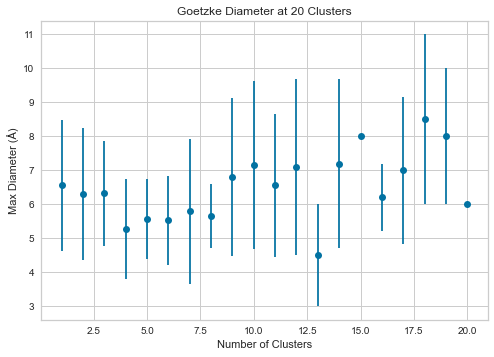

In [126]:
x = np.linspace(1,20,20)

vx, vy = properties(scaledD,mdiameter,20,vbool=False)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x, vx, yerr=vy, fmt='o',label = 'Goetzke')
plt.title('Goetzke Diameter at 20 Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Max Diameter (Å)')

In [8]:
x,y = Kmeansresults(scaledA,3,3,False)
print(y)

[130, 97, 26]


In [10]:
x,y = Kmeansresults(scaledB,3,3,False)
print(y)

[129, 96, 28]


In [18]:
x,y = Kmeansresults(scaledB,11,3,False)
print(y)
print(x)
for i in x:
    print(i)

[45, 52, 14, 38, 45, 10, 3, 21, 3, 18, 4]
defaultdict(<class 'list'>, {4: ['ABW', 'AFG', 'AFR', 'AST', 'ASV', 'ATN', 'ATS', 'AVE', 'AWW', 'BCT', 'CAN', 'CGF', 'CHI', 'DFO', 'EZT', 'FAR', 'FRA', 'GIU', 'IFR', 'IFY', 'IRN', 'ITV', 'JBW', 'JSN', 'JSW', 'LAU', 'LIO', 'LIT', 'LOS', 'LTN', 'MAR', 'MSO', 'PAR', 'RON', 'SAO', 'SAS', 'SAT', 'SFO', 'SOD', 'SSF', 'TOL', 'UOZ', 'USI', 'ZON', 'PTT'], 0: ['ACO', 'AEI', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'APC', 'ATT', 'AVL', 'BPH', 'BSV', 'CHA', 'CLO', 'EAB', 'EMT', 'ERI', 'FAU', 'GIS', 'GME', 'KFI', 'LEV', 'LTA', 'LTF', 'LTL', 'MER', 'MOZ', 'MRT', 'MWF', 'OFF', 'PAU', 'PHI', 'PUN', 'PWN', 'RHO', 'SAV', 'SBN', 'SBS', 'SBT', 'SFW', 'SIV', 'SWY', 'TSC', 'WEN', 'SYT'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'ATO', 'ATV', 'IFO', 'OSI', 'PSI', 'SAF', 'VFI'], 9: ['AFN', 'ANA', 'AWO', 'CGS', 'CZP', 'DFT', 'EDI', 'ETR', 'GOO', 'JNT', 'LTJ', 'NAT', 'OWE', 'POR', 'SBE', 'SOS', 'THO', 'UEI'], 1: ['BEC', 'BOF', 'BOG', 'BRE', 'CON', 'CSV', 'EON', 'E

In [13]:
x,y = Kmeansresults(scaledA,11,3,False)
print(y)

[10, 19, 16, 38, 8, 38, 42, 22, 4, 52, 4]


In [55]:
unique_combinations = []

list1 = [1,2,3,4]
list2 = [1,2,3,4]
# Getting all permutations of list_1
# with length of list_2
permut = itertools.permutations(list1, len(list2))
 
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, list2)
    unique_combinations.append(list(zipped))

# printing unique_combination list
#print(unique_combinations)
for i in unique_combinations:
    print(i)

#print(len(unique_combinations))


[(1, 1), (2, 2), (3, 3), (4, 4)]
[(1, 1), (2, 2), (4, 3), (3, 4)]
[(1, 1), (3, 2), (2, 3), (4, 4)]
[(1, 1), (3, 2), (4, 3), (2, 4)]
[(1, 1), (4, 2), (2, 3), (3, 4)]
[(1, 1), (4, 2), (3, 3), (2, 4)]
[(2, 1), (1, 2), (3, 3), (4, 4)]
[(2, 1), (1, 2), (4, 3), (3, 4)]
[(2, 1), (3, 2), (1, 3), (4, 4)]
[(2, 1), (3, 2), (4, 3), (1, 4)]
[(2, 1), (4, 2), (1, 3), (3, 4)]
[(2, 1), (4, 2), (3, 3), (1, 4)]
[(3, 1), (1, 2), (2, 3), (4, 4)]
[(3, 1), (1, 2), (4, 3), (2, 4)]
[(3, 1), (2, 2), (1, 3), (4, 4)]
[(3, 1), (2, 2), (4, 3), (1, 4)]
[(3, 1), (4, 2), (1, 3), (2, 4)]
[(3, 1), (4, 2), (2, 3), (1, 4)]
[(4, 1), (1, 2), (2, 3), (3, 4)]
[(4, 1), (1, 2), (3, 3), (2, 4)]
[(4, 1), (2, 2), (1, 3), (3, 4)]
[(4, 1), (2, 2), (3, 3), (1, 4)]
[(4, 1), (3, 2), (1, 3), (2, 4)]
[(4, 1), (3, 2), (2, 3), (1, 4)]


In [56]:
unique_combinations = []

list1 = ['a','b','c','d']
list2 = ['e','f','j','h']
# Getting all permutations of list_1
# with length of list_2
permut = itertools.permutations(list1, len(list2))
 
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, list2)
    unique_combinations.append(list(zipped))

# printing unique_combination list
#print(unique_combinations)
for i in unique_combinations:
    print(i)

#print(len(unique_combinations))

[('a', 'e'), ('b', 'f'), ('c', 'j'), ('d', 'h')]
[('a', 'e'), ('b', 'f'), ('d', 'j'), ('c', 'h')]
[('a', 'e'), ('c', 'f'), ('b', 'j'), ('d', 'h')]
[('a', 'e'), ('c', 'f'), ('d', 'j'), ('b', 'h')]
[('a', 'e'), ('d', 'f'), ('b', 'j'), ('c', 'h')]
[('a', 'e'), ('d', 'f'), ('c', 'j'), ('b', 'h')]
[('b', 'e'), ('a', 'f'), ('c', 'j'), ('d', 'h')]
[('b', 'e'), ('a', 'f'), ('d', 'j'), ('c', 'h')]
[('b', 'e'), ('c', 'f'), ('a', 'j'), ('d', 'h')]
[('b', 'e'), ('c', 'f'), ('d', 'j'), ('a', 'h')]
[('b', 'e'), ('d', 'f'), ('a', 'j'), ('c', 'h')]
[('b', 'e'), ('d', 'f'), ('c', 'j'), ('a', 'h')]
[('c', 'e'), ('a', 'f'), ('b', 'j'), ('d', 'h')]
[('c', 'e'), ('a', 'f'), ('d', 'j'), ('b', 'h')]
[('c', 'e'), ('b', 'f'), ('a', 'j'), ('d', 'h')]
[('c', 'e'), ('b', 'f'), ('d', 'j'), ('a', 'h')]
[('c', 'e'), ('d', 'f'), ('a', 'j'), ('b', 'h')]
[('c', 'e'), ('d', 'f'), ('b', 'j'), ('a', 'h')]
[('d', 'e'), ('a', 'f'), ('b', 'j'), ('c', 'h')]
[('d', 'e'), ('a', 'f'), ('c', 'j'), ('b', 'h')]
[('d', 'e'), ('b', '

In [65]:
d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
nclusters = 11
list1,y = Kmeansresults(scaledA,11,1,False)
list2,y = Kmeansresults(scaledB,11,1,False)

l1 = range(nclusters)
l2 = range(nclusters)
unique_comb = list(itertools.product(l1,l2))

for u in unique_comb:
    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
    print('u0 is',u[0])
    print('u1 is',u[1])
print(d1)   
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
m = 0

print(d1)

for key in d1.keys():
    val1 = key//nclusters
    val2 = key - val1*nclusters
    #d1[key] = score()
    
m = 0
for comb in permut:
    x = 0
    zipped = list(zip(comb, l2))
    for i in range(nclusters):
        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
    if x > m:
        m = x
print(m)  

u0 is 0
u1 is 0
u0 is 0
u1 is 1
u0 is 0
u1 is 2
u0 is 0
u1 is 3
u0 is 0
u1 is 4
u0 is 0
u1 is 5
u0 is 0
u1 is 6
u0 is 0
u1 is 7
u0 is 0
u1 is 8
u0 is 0
u1 is 9
u0 is 0
u1 is 10
u0 is 1
u1 is 0
u0 is 1
u1 is 1
u0 is 1
u1 is 2
u0 is 1
u1 is 3
u0 is 1
u1 is 4
u0 is 1
u1 is 5
u0 is 1
u1 is 6
u0 is 1
u1 is 7
u0 is 1
u1 is 8
u0 is 1
u1 is 9
u0 is 1
u1 is 10
u0 is 2
u1 is 0
u0 is 2
u1 is 1
u0 is 2
u1 is 2
u0 is 2
u1 is 3
u0 is 2
u1 is 4
u0 is 2
u1 is 5
u0 is 2
u1 is 6
u0 is 2
u1 is 7
u0 is 2
u1 is 8
u0 is 2
u1 is 9
u0 is 2
u1 is 10
u0 is 3
u1 is 0
u0 is 3
u1 is 1
u0 is 3
u1 is 2
u0 is 3
u1 is 3
u0 is 3
u1 is 4
u0 is 3
u1 is 5
u0 is 3
u1 is 6
u0 is 3
u1 is 7
u0 is 3
u1 is 8
u0 is 3
u1 is 9
u0 is 3
u1 is 10
u0 is 4
u1 is 0
u0 is 4
u1 is 1
u0 is 4
u1 is 2
u0 is 4
u1 is 3
u0 is 4
u1 is 4
u0 is 4
u1 is 5
u0 is 4
u1 is 6
u0 is 4
u1 is 7
u0 is 4
u1 is 8
u0 is 4
u1 is 9
u0 is 4
u1 is 10
u0 is 5
u1 is 0
u0 is 5
u1 is 1
u0 is 5
u1 is 2
u0 is 5
u1 is 3
u0 is 5
u1 is 4
u0 is 5
u1 is 5
u0 is 5
u1 is 6
u0 

In [66]:
d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
nclusters = 11
list1,y = Kmeansresults(scaledA,11,1,False)
list2,y = Kmeansresults(scaledC,11,1,False)

l1 = range(nclusters)
l2 = range(nclusters)
unique_comb = list(itertools.product(l1,l2))

for u in unique_comb:
    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
    print('u0 is',u[0])
    print('u1 is',u[1])
print(d1)   
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
m = 0

print(d1)

for key in d1.keys():
    val1 = key//nclusters
    val2 = key - val1*nclusters
    #d1[key] = score()
    
m = 0
for comb in permut:
    x = 0
    zipped = list(zip(comb, l2))
    for i in range(nclusters):
        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
    if x > m:
        m = x
print(m)  

u0 is 0
u1 is 0
u0 is 0
u1 is 1
u0 is 0
u1 is 2
u0 is 0
u1 is 3
u0 is 0
u1 is 4
u0 is 0
u1 is 5
u0 is 0
u1 is 6
u0 is 0
u1 is 7
u0 is 0
u1 is 8
u0 is 0
u1 is 9
u0 is 0
u1 is 10
u0 is 1
u1 is 0
u0 is 1
u1 is 1
u0 is 1
u1 is 2
u0 is 1
u1 is 3
u0 is 1
u1 is 4
u0 is 1
u1 is 5
u0 is 1
u1 is 6
u0 is 1
u1 is 7
u0 is 1
u1 is 8
u0 is 1
u1 is 9
u0 is 1
u1 is 10
u0 is 2
u1 is 0
u0 is 2
u1 is 1
u0 is 2
u1 is 2
u0 is 2
u1 is 3
u0 is 2
u1 is 4
u0 is 2
u1 is 5
u0 is 2
u1 is 6
u0 is 2
u1 is 7
u0 is 2
u1 is 8
u0 is 2
u1 is 9
u0 is 2
u1 is 10
u0 is 3
u1 is 0
u0 is 3
u1 is 1
u0 is 3
u1 is 2
u0 is 3
u1 is 3
u0 is 3
u1 is 4
u0 is 3
u1 is 5
u0 is 3
u1 is 6
u0 is 3
u1 is 7
u0 is 3
u1 is 8
u0 is 3
u1 is 9
u0 is 3
u1 is 10
u0 is 4
u1 is 0
u0 is 4
u1 is 1
u0 is 4
u1 is 2
u0 is 4
u1 is 3
u0 is 4
u1 is 4
u0 is 4
u1 is 5
u0 is 4
u1 is 6
u0 is 4
u1 is 7
u0 is 4
u1 is 8
u0 is 4
u1 is 9
u0 is 4
u1 is 10
u0 is 5
u1 is 0
u0 is 5
u1 is 1
u0 is 5
u1 is 2
u0 is 5
u1 is 3
u0 is 5
u1 is 4
u0 is 5
u1 is 5
u0 is 5
u1 is 6
u0 

In [67]:
d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
nclusters = 11
list1,y = Kmeansresults(scaledA,11,1,False)
list2,y = Kmeansresults(scaledD,11,1,False)

l1 = range(nclusters)
l2 = range(nclusters)
unique_comb = list(itertools.product(l1,l2))

for u in unique_comb:
    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
    print('u0 is',u[0])
    print('u1 is',u[1])
print(d1)   
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
m = 0

print(d1)

for key in d1.keys():
    val1 = key//nclusters
    val2 = key - val1*nclusters
    #d1[key] = score()
    
m = 0
for comb in permut:
    x = 0
    zipped = list(zip(comb, l2))
    for i in range(nclusters):
        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
    if x > m:
        m = x
print(m)  

u0 is 0
u1 is 0
u0 is 0
u1 is 1
u0 is 0
u1 is 2
u0 is 0
u1 is 3
u0 is 0
u1 is 4
u0 is 0
u1 is 5
u0 is 0
u1 is 6
u0 is 0
u1 is 7
u0 is 0
u1 is 8
u0 is 0
u1 is 9
u0 is 0
u1 is 10
u0 is 1
u1 is 0
u0 is 1
u1 is 1
u0 is 1
u1 is 2
u0 is 1
u1 is 3
u0 is 1
u1 is 4
u0 is 1
u1 is 5
u0 is 1
u1 is 6
u0 is 1
u1 is 7
u0 is 1
u1 is 8
u0 is 1
u1 is 9
u0 is 1
u1 is 10
u0 is 2
u1 is 0
u0 is 2
u1 is 1
u0 is 2
u1 is 2
u0 is 2
u1 is 3
u0 is 2
u1 is 4
u0 is 2
u1 is 5
u0 is 2
u1 is 6
u0 is 2
u1 is 7
u0 is 2
u1 is 8
u0 is 2
u1 is 9
u0 is 2
u1 is 10
u0 is 3
u1 is 0
u0 is 3
u1 is 1
u0 is 3
u1 is 2
u0 is 3
u1 is 3
u0 is 3
u1 is 4
u0 is 3
u1 is 5
u0 is 3
u1 is 6
u0 is 3
u1 is 7
u0 is 3
u1 is 8
u0 is 3
u1 is 9
u0 is 3
u1 is 10
u0 is 4
u1 is 0
u0 is 4
u1 is 1
u0 is 4
u1 is 2
u0 is 4
u1 is 3
u0 is 4
u1 is 4
u0 is 4
u1 is 5
u0 is 4
u1 is 6
u0 is 4
u1 is 7
u0 is 4
u1 is 8
u0 is 4
u1 is 9
u0 is 4
u1 is 10
u0 is 5
u1 is 0
u0 is 5
u1 is 1
u0 is 5
u1 is 2
u0 is 5
u1 is 3
u0 is 5
u1 is 4
u0 is 5
u1 is 5
u0 is 5
u1 is 6
u0 

In [68]:
d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
nclusters = 11
list1,y = Kmeansresults(scaledB,11,1,False)
list2,y = Kmeansresults(scaledC,11,1,False)

l1 = range(nclusters)
l2 = range(nclusters)
unique_comb = list(itertools.product(l1,l2))

for u in unique_comb:
    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
    print('u0 is',u[0])
    print('u1 is',u[1])
print(d1)   
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
m = 0

print(d1)

for key in d1.keys():
    val1 = key//nclusters
    val2 = key - val1*nclusters
    #d1[key] = score()
    
m = 0
for comb in permut:
    x = 0
    zipped = list(zip(comb, l2))
    for i in range(nclusters):
        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
    if x > m:
        m = x
print(m)  

u0 is 0
u1 is 0
u0 is 0
u1 is 1
u0 is 0
u1 is 2
u0 is 0
u1 is 3
u0 is 0
u1 is 4
u0 is 0
u1 is 5
u0 is 0
u1 is 6
u0 is 0
u1 is 7
u0 is 0
u1 is 8
u0 is 0
u1 is 9
u0 is 0
u1 is 10
u0 is 1
u1 is 0
u0 is 1
u1 is 1
u0 is 1
u1 is 2
u0 is 1
u1 is 3
u0 is 1
u1 is 4
u0 is 1
u1 is 5
u0 is 1
u1 is 6
u0 is 1
u1 is 7
u0 is 1
u1 is 8
u0 is 1
u1 is 9
u0 is 1
u1 is 10
u0 is 2
u1 is 0
u0 is 2
u1 is 1
u0 is 2
u1 is 2
u0 is 2
u1 is 3
u0 is 2
u1 is 4
u0 is 2
u1 is 5
u0 is 2
u1 is 6
u0 is 2
u1 is 7
u0 is 2
u1 is 8
u0 is 2
u1 is 9
u0 is 2
u1 is 10
u0 is 3
u1 is 0
u0 is 3
u1 is 1
u0 is 3
u1 is 2
u0 is 3
u1 is 3
u0 is 3
u1 is 4
u0 is 3
u1 is 5
u0 is 3
u1 is 6
u0 is 3
u1 is 7
u0 is 3
u1 is 8
u0 is 3
u1 is 9
u0 is 3
u1 is 10
u0 is 4
u1 is 0
u0 is 4
u1 is 1
u0 is 4
u1 is 2
u0 is 4
u1 is 3
u0 is 4
u1 is 4
u0 is 4
u1 is 5
u0 is 4
u1 is 6
u0 is 4
u1 is 7
u0 is 4
u1 is 8
u0 is 4
u1 is 9
u0 is 4
u1 is 10
u0 is 5
u1 is 0
u0 is 5
u1 is 1
u0 is 5
u1 is 2
u0 is 5
u1 is 3
u0 is 5
u1 is 4
u0 is 5
u1 is 5
u0 is 5
u1 is 6
u0 

In [69]:
d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
nclusters = 11
list1,y = Kmeansresults(scaledC,11,1,False)
list2,y = Kmeansresults(scaledD,11,1,False)

l1 = range(nclusters)
l2 = range(nclusters)
unique_comb = list(itertools.product(l1,l2))

for u in unique_comb:
    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
    print('u0 is',u[0])
    print('u1 is',u[1])
print(d1)   
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
m = 0

print(d1)

for key in d1.keys():
    val1 = key//nclusters
    val2 = key - val1*nclusters
    #d1[key] = score()
    
m = 0
for comb in permut:
    x = 0
    zipped = list(zip(comb, l2))
    for i in range(nclusters):
        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
    if x > m:
        m = x
print(m)  

u0 is 0
u1 is 0
u0 is 0
u1 is 1
u0 is 0
u1 is 2
u0 is 0
u1 is 3
u0 is 0
u1 is 4
u0 is 0
u1 is 5
u0 is 0
u1 is 6
u0 is 0
u1 is 7
u0 is 0
u1 is 8
u0 is 0
u1 is 9
u0 is 0
u1 is 10
u0 is 1
u1 is 0
u0 is 1
u1 is 1
u0 is 1
u1 is 2
u0 is 1
u1 is 3
u0 is 1
u1 is 4
u0 is 1
u1 is 5
u0 is 1
u1 is 6
u0 is 1
u1 is 7
u0 is 1
u1 is 8
u0 is 1
u1 is 9
u0 is 1
u1 is 10
u0 is 2
u1 is 0
u0 is 2
u1 is 1
u0 is 2
u1 is 2
u0 is 2
u1 is 3
u0 is 2
u1 is 4
u0 is 2
u1 is 5
u0 is 2
u1 is 6
u0 is 2
u1 is 7
u0 is 2
u1 is 8
u0 is 2
u1 is 9
u0 is 2
u1 is 10
u0 is 3
u1 is 0
u0 is 3
u1 is 1
u0 is 3
u1 is 2
u0 is 3
u1 is 3
u0 is 3
u1 is 4
u0 is 3
u1 is 5
u0 is 3
u1 is 6
u0 is 3
u1 is 7
u0 is 3
u1 is 8
u0 is 3
u1 is 9
u0 is 3
u1 is 10
u0 is 4
u1 is 0
u0 is 4
u1 is 1
u0 is 4
u1 is 2
u0 is 4
u1 is 3
u0 is 4
u1 is 4
u0 is 4
u1 is 5
u0 is 4
u1 is 6
u0 is 4
u1 is 7
u0 is 4
u1 is 8
u0 is 4
u1 is 9
u0 is 4
u1 is 10
u0 is 5
u1 is 0
u0 is 5
u1 is 1
u0 is 5
u1 is 2
u0 is 5
u1 is 3
u0 is 5
u1 is 4
u0 is 5
u1 is 5
u0 is 5
u1 is 6
u0 

In [70]:
d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
nclusters = 11
list1,y = Kmeansresults(scaledC,11,1,False)
list2,y = Kmeansresults(scaledD,11,1,False)

l1 = range(nclusters)
l2 = range(nclusters)
unique_comb = list(itertools.product(l1,l2))

for u in unique_comb:
    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
    print('u0 is',u[0])
    print('u1 is',u[1])
print(d1)   
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
m = 0

print(d1)

for key in d1.keys():
    val1 = key//nclusters
    val2 = key - val1*nclusters
    #d1[key] = score()
    
m = 0
for comb in permut:
    x = 0
    zipped = list(zip(comb, l2))
    for i in range(nclusters):
        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
    if x > m:
        m = x
print(m)  

u0 is 0
u1 is 0
u0 is 0
u1 is 1
u0 is 0
u1 is 2
u0 is 0
u1 is 3
u0 is 0
u1 is 4
u0 is 0
u1 is 5
u0 is 0
u1 is 6
u0 is 0
u1 is 7
u0 is 0
u1 is 8
u0 is 0
u1 is 9
u0 is 0
u1 is 10
u0 is 1
u1 is 0
u0 is 1
u1 is 1
u0 is 1
u1 is 2
u0 is 1
u1 is 3
u0 is 1
u1 is 4
u0 is 1
u1 is 5
u0 is 1
u1 is 6
u0 is 1
u1 is 7
u0 is 1
u1 is 8
u0 is 1
u1 is 9
u0 is 1
u1 is 10
u0 is 2
u1 is 0
u0 is 2
u1 is 1
u0 is 2
u1 is 2
u0 is 2
u1 is 3
u0 is 2
u1 is 4
u0 is 2
u1 is 5
u0 is 2
u1 is 6
u0 is 2
u1 is 7
u0 is 2
u1 is 8
u0 is 2
u1 is 9
u0 is 2
u1 is 10
u0 is 3
u1 is 0
u0 is 3
u1 is 1
u0 is 3
u1 is 2
u0 is 3
u1 is 3
u0 is 3
u1 is 4
u0 is 3
u1 is 5
u0 is 3
u1 is 6
u0 is 3
u1 is 7
u0 is 3
u1 is 8
u0 is 3
u1 is 9
u0 is 3
u1 is 10
u0 is 4
u1 is 0
u0 is 4
u1 is 1
u0 is 4
u1 is 2
u0 is 4
u1 is 3
u0 is 4
u1 is 4
u0 is 4
u1 is 5
u0 is 4
u1 is 6
u0 is 4
u1 is 7
u0 is 4
u1 is 8
u0 is 4
u1 is 9
u0 is 4
u1 is 10
u0 is 5
u1 is 0
u0 is 5
u1 is 1
u0 is 5
u1 is 2
u0 is 5
u1 is 3
u0 is 5
u1 is 4
u0 is 5
u1 is 5
u0 is 5
u1 is 6
u0 

In [ ]:
o = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])
#d2 is dictionary for average and std calculations
d2 = defaultdict(list)
for i in range(1,500,20):
    c = 0
    d = 0
    for t in o:
        for n in range(d,4):
            if c != d:
                print(1)
                d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
                nclusters = 11
                list1,y = Kmeansresults(t,11,i,False)
                list2,y = Kmeansresults(o[d],11,i,False)

                l1 = range(nclusters)
                l2 = range(nclusters)
                unique_comb = list(itertools.product(l1,l2))
    
                for u in unique_comb:
                    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
        
                permut = itertools.permutations(l1, len(l2))
                # zip() is called to pair each permutation
                # and shorter list element into combination
                m = 0
                d = d+1

    
                m = 0
                for comb in permut:
                    x = 0
                    zipped = list(zip(comb, l2))
                    for i in range(nclusters):
                        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
                    if x > m:
                        m = x
                print(t,o[d],m/253)
                if c == d:
                    compare_array[c,d] = 1
                    compare_array[d,c] = 1
                else:
                    compare_array[c,d] = m/253
                    compare_array[d,c] = m/253
                    d2[c*d+d].append(m)
            c = c + 1
    print(d2)
    print(compare_array)

In [ ]:
o = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])
#d2 is dictionary for average and std calculations
d2 = defaultdict(list)
for i in range(1,500,20):
    c = 0
    d = 0
    for t in o:
        for n in range(d,4):
            if c != d:
                print(1)
                d1 = defaultdict(int) # (a, b) -> score   # key = 5*a + b 
                nclusters = 12
                list1,y = Kmeansresults(t,12,i,False)
                list2,y = Kmeansresults(o[d],12,i,False)

                l1 = range(nclusters)
                l2 = range(nclusters)
                unique_comb = list(itertools.product(l1,l2))
    
                for u in unique_comb:
                    d1[nclusters*u[0]+u[1]] =  len(list(set(list1[u[0]]).intersection(list2[u[1]])))
        
                permut = itertools.permutations(l1, len(l2))
                # zip() is called to pair each permutation
                # and shorter list element into combination
                m = 0
                d = d+1

    
                m = 0
                for comb in permut:
                    x = 0
                    zipped = list(zip(comb, l2))
                    for i in range(nclusters):
                        x = d1[zipped[i][0]*nclusters+zipped[i][1]] + x
                    if x > m:
                        m = x
                print(t,o[d],m/253)
                if c == d:
                    compare_array[c,d] = 1
                    compare_array[d,c] = 1
                else:
                    compare_array[c,d] = m/253
                    compare_array[d,c] = m/253
                    d2[c*d+d].append(m)
            c = c + 1
    print(d2)
    print(compare_array)

In [92]:
if scaledA.all() != scaledA.all():
    print(1)
    
print(scaledD.all() != scaledA.all())

False


In [43]:
permut = itertools.permutations(l1, len(l2))
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, Blist)
    print(list(zipped))

[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (3, 0), (

[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (3, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (3, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (5, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (3, 2)]
[(0, 1), (1, 4)

[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (6, 0), (

[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (3, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (7, 0), (

[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (8, 0), (

[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (2, 3), (9, 0), (

[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), 

[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), 

[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), 

[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), 

[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), 

[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), (9, 2)]
[(0, 1), (1, 4), (2, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (

[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (2, 0), (

[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (2, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (4, 0), (

[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (2, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (5, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (2, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (6, 0), (

[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (2, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (7, 0), (

[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (2, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (9, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (8, 0), (

[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (2, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (4, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (5, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (6, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (7, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (8, 2)]
[(0, 1), (1, 4),

[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (9, 0), (10, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (2, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (4, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (5, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (6, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (7, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), (8, 2)]
[(0, 1), (1, 4), (3, 3), (10, 0), 

KeyboardInterrupt: 